In [1]:
import os
import numpy as np
import tifffile
from tqdm import tqdm


def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.

    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if (f.endswith(".tiff") or f.endswith(".tif"))
        ]
    )

    tiff_sequence = tifffile.TiffSequence(tiff_files)

    # Get the total number of TIFF files
    total_files = len(tiff_files)

    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)

            # Update progress
            pbar.update(1)

    return np.array(volume)

c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\alberto.vicente\Documents\lunas\.conda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.

    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tifffile.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)

    print("Saving complete.")

In [4]:
from pathlib import Path

folder1 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/2/bot_eq_aligned_centered"
)
folder2 = Path(
    "C:/Users/alberto.vicente/Documents/temporal/volumenes/2/top_eq_aligned_centered"
)

bot = read_sequence(folder1)
top = read_sequence(folder2)

Progress: 100%|██████████| 4528/4528 [00:16<00:00, 269.27it/s]


In [5]:
from skimage.filters import threshold_otsu
import scipy.ndimage as ndimage
from skimage.measure import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt


def get_translation(volume, show=False, top_threshold=255):
    middle_slice = volume[len(volume) // 2]

    top_index = np.where(middle_slice > top_threshold)

    threshold_value = threshold_otsu(middle_slice[middle_slice > 50])

    print("threshold value is: ", threshold_value)

    thresholded_slice = middle_slice > threshold_value

    thresholded_slice[top_index] = 0

    # Label the objects in the thresholded slice
    labeled_slice = label(thresholded_slice)

    # Get the properties of each labeled region
    regions = regionprops(labeled_slice)

    # Find the largest connected component
    largest_component = max(regions, key=lambda region: region.area)

    # Create a mask to keep only the largest component
    mask = np.zeros_like(labeled_slice)
    mask[labeled_slice == largest_component.label] = 1

    # Apply the mask to the thresholded slice
    thresholded_slice = thresholded_slice * mask

    # find the center of mass of the largest component
    center_of_mass = ndimage.measurements.center_of_mass(mask)

    # center the image in the center of mass
    center = np.array(middle_slice.shape) // 2
    shift = np.array(center) - np.array(center_of_mass)
    shifted_slice = ndimage.shift(thresholded_slice, shift)

    if show:
        plt.hist(middle_slice[middle_slice > 50].ravel(), bins=256)
        plt.title("Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.axvline(threshold_value, color="r", linestyle="dashed", linewidth=2)
        plt.show()

        # Print the rotation angle
        print(f"The center of the largest component is {center_of_mass}.")

        # Plotting the original middle slice
        plt.subplot(2, 2, 1)
        plt.imshow(middle_slice, cmap="gray")
        plt.title("Original Middle Slice")

        # Plotting the thresholded slice
        plt.subplot(2, 2, 2)
        plt.imshow(thresholded_slice, cmap="gray")
        plt.title("Thresholded Slice")

        # Plotting the largest component mask
        plt.subplot(2, 2, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Largest Component Mask")

        # Plotting the rotated slice
        plt.subplot(2, 2, 4)
        plt.imshow(shifted_slice, cmap="gray")
        plt.title("Centered Slice")

        # Adjusting the layout and displaying the plot
        plt.tight_layout()
        plt.show()

    return shift

In [6]:
def shift_slice(args):
    """
    Shifts a slice by a given shift value.

    Args:
    slice_data (numpy.ndarray): The input slice.
    shift (tuple): The shift value in each dimension.

    Returns:
    numpy.ndarray: The shifted slice.
    """

    slice_data, shift = args

    shifted_slice = ndimage.shift(slice_data, shift, mode="constant", cval=0)
    return shifted_slice

In [ ]:
from concurrent.futures import ThreadPoolExecutor


def shift_volume_concurrent(volume, shift):
    """
    Apply autothreshold_slice to each slice in a volume concurrently with a progress bar.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.

    Returns:
    numpy.ndarray: A 3D array where each slice is thresholded.
    """
    shifted_volume = np.zeros_like(volume)

    with ThreadPoolExecutor() as executor:
        args = [(volume[i], shift) for i in range(volume.shape[0])]
        for i, result in enumerate(
            tqdm(
                executor.map(shift_slice, args), total=volume.shape[0], desc="Shifting"
            )
        ):
            shifted_volume[i] = result

    return np.array(shifted_volume)

In [ ]:
def crop_volume(volume, x, y):
    """
    Crop a volume from the center to the new dimensions.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    x (int): The new x dimension.
    y (int): The new y dimension.

    Returns:
    numpy.ndarray: The cropped volume.
    """
    z, old_x, old_y = volume.shape
    start_x = (old_x - x) // 2
    start_y = (old_y - y) // 2
    end_x = start_x + x
    end_y = start_y + y

    cropped_volume = volume[:, start_x:end_x, start_y:end_y]

    return cropped_volume

In [ ]:
def crop_slice(volume, x, y):
    """
    Crop a volume from the center to the new dimensions.

    Args:
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    x (int): The new x dimension.
    y (int): The new y dimension.

    Returns:
    numpy.ndarray: The cropped volume.
    """
    old_x, old_y = volume.shape
    start_x = (old_x - x) // 2
    start_y = (old_y - y) // 2
    end_x = start_x + x
    end_y = start_y + y

    # print all variables
    print("old_x: ", old_x)
    print("old_y: ", old_y)
    print("start_x: ", start_x)
    print("start_y: ", start_y)
    print("end_x: ", end_x)
    print("end_y: ", end_y)

    cropped_volume = volume[start_x:end_x, start_y:end_y]

    return cropped_volume

In [ ]:
bot.shape

(4452, 2111, 432)

old_x:  2111
old_y:  432
start_x:  80
start_y:  16
end_x:  2030
end_y:  416


Text(0.5, 1.0, 'Original Cropped Slice')

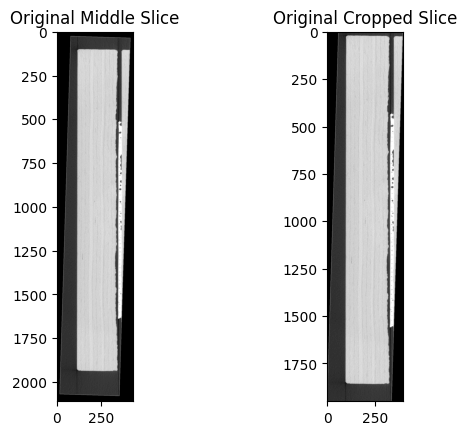

In [ ]:
middle_slice = bot[len(bot) // 2]

cropped_slice = crop_slice(middle_slice, 1950, 400)

# plot both slices using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(middle_slice, cmap="gray")
plt.title("Original Middle Slice")
# plot both slices using matplotlib
plt.subplot(1, 2, 2)
plt.imshow(cropped_slice, cmap="gray")
plt.title("Original Cropped Slice")

threshold value is:  136


C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_19436\3221796900.py:41: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center_of_mass = ndimage.measurements.center_of_mass(mask)


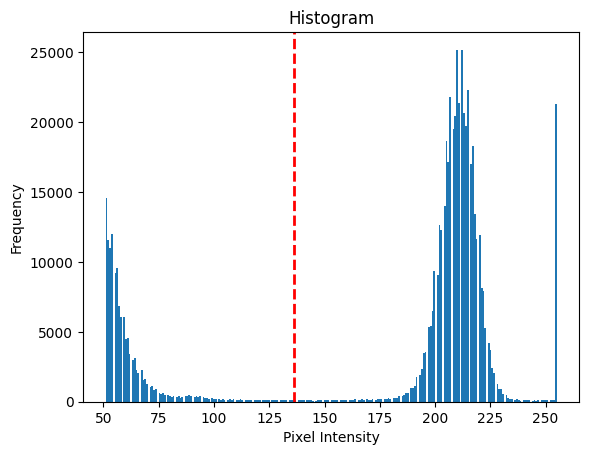

The center of the largest component is (1022.8017517173699, 225.65937438665358).


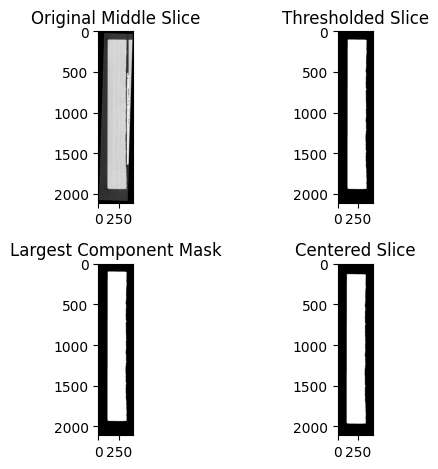

Shifting: 100%|██████████| 4452/4452 [00:22<00:00, 201.15it/s]


In [ ]:
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(bot))
random_slice = bot[random_index]

# Translate the slice
shift = get_translation(bot, show=True, top_threshold=245)

# shift volume
shifted_bot = shift_volume_concurrent(bot, shift)

In [57]:
import shutil

output_folder = Path(r"C:\Users\alberto.vicente\Documents\temporal\volumenes\2\output")

# delete output folder if exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

write_sequence(output_folder, "bot_centered", shifted_bot)

Saving: 100%|██████████| 4452/4452 [00:13<00:00, 334.73it/s]

Saving complete.
